In [3]:
import numpy as np  
import pandas as pd 
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile
from pathlib import Path
import xml.etree.ElementTree as ET
from shutil import copyfile
import os
import random
from shutil import copyfile
from tqdm import tqdm
import yaml
from sklearn.model_selection import train_test_split
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


!mkdir -p Dataset/labels
!mkdir -p Dataset/images
!git clone https://github.com/ultralytics/ultralytics
!pip install ultralytics
!pip install torch
from ultralytics import YOLO
import torch



Cloning into 'ultralytics'...
remote: Enumerating objects: 48594, done.
remote: Counting objects: 100% (311/311), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 48594 (delta 242), reused 214 (delta 196), pack-reused 48283 (from 4)
Receiving objects: 100% (48594/48594), 40.62 MiB | 1.32 MiB/s, done.
Resolving deltas: 100% (35770/35770), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.8/906.8 kB 555.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 429.5 kB/s eta 0:00:0000:0100:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 1.2 MB/s eta 0:00:0000:0100:020m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 857.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 1.4 MB/s eta 0:00:0000:01

[notice] A new rele

In [6]:
classes = ['helmet','head','person']

def convert_annot(size , box):
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

In [7]:
def save_txt_file(img_jpg_file_name, size, img_box):
    save_file_name = '/kaggle/working/Dataset/labels/' +  img_jpg_file_name + '.txt'
    
    #file_path = open(save_file_name, "a+")
    with open(save_file_name ,'a+') as file_path:
        for box in img_box:

            cls_num = classes.index(box[0])

            new_box = convert_annot(size, box[1:])

            file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

        file_path.flush()
        file_path.close()

In [8]:
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'

    tree = ET.parse(img_path)
    root = tree.getroot()

    img_name = root.find("filename").text
    img_size = root.find("size")
    img_w = int(img_size.find("width").text)
    img_h = int(img_size.find("height").text)
    img_c = int(img_size.find("depth").text)

    img_box = []
    for box in root.findall("object"):
        cls_name = box.find("name").text
        x1 = int(box.find("bndbox").find("xmin").text)
        y1 = int(box.find("bndbox").find("ymin").text)
        x2 = int(box.find("bndbox").find("xmax").text)
        y2 = int(box.find("bndbox").find("ymax").text)

        img_box.append([cls_name, x1, y1, x2, y2])

    img_jpg_file_name = img_xml_file + '.jpg'
    save_txt_file(img_xml_file, [img_w, img_h], img_box)

In [9]:
from tqdm import tqdm

files = os.listdir('/kaggle/input/hard-hat-detection/annotations')
for file in tqdm(files, total=len(files)):
    file_xml = file.split(".")
    get_xml_data('/kaggle/input/hard-hat-detection/annotations', file_xml[0])

100%|██████████| 5000/5000 [00:21<00:00, 234.93it/s]


# Dataset Split : 80% Train, 10% Val & 10% Test.

In [10]:
image_list = os.listdir('/kaggle/input/hard-hat-detection/annotations')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=42)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=42)
print('total =', len(image_list))
print('train :', len(train_list))
print('val   :', len(val_list))
print('test  :', len(test_list))

total = 5000
train : 4000
val   : 500
test  : 500


In [24]:
def split_and_copy_images(imgs_source, labels_source, dataset_root, split_ratio=(0.7, 0.2, 0.1)):
    """Splits data based on existing labels and copies corresponding images."""

    label_files = [f for f in os.listdir(labels_source) if f.endswith('.txt')]
    num_labels = len(label_files)
    
    for mode in ["train", "val", "test"]:
        (dataset_root / "images" / mode).mkdir(parents=True, exist_ok=True)

    random.shuffle(label_files)

    train_ratio, val_ratio, test_ratio = split_ratio
    total_files = num_labels
    train_count = int(total_files * train_ratio)
    val_count = int(total_files * val_ratio)

    train_files = label_files[:train_count]
    val_files = label_files[train_count:train_count + val_count]
    test_files = label_files[train_count + val_count:]

    modes = [("train", train_files), ("val", val_files), ("test", test_files)]

    for mode, file_list in modes:
        for label_file in tqdm(file_list, desc=f"Copying {mode} images"):
            base_filename = Path(label_file).stem
            img_src_file = Path(imgs_source) / (base_filename + ".png") 
            img_dest_file = dataset_root / "images" / mode / (base_filename + ".png")

            if img_src_file.exists(): #check if image exist
                copyfile(img_src_file, img_dest_file)
            else:
                print(f"Image not found for label {label_file}")

imgs_source = "/kaggle/input/hard-hat-detection/images"
labels_source = "/kaggle/working/Dataset/labels" 
dataset_root = Path("/kaggle/working/Dataset")

split_and_copy_images(imgs_source, labels_source, dataset_root)

!ls -R /kaggle/working/Dataset

Copying test images: 100%|██████████| 500/500 [00:05<00:00, 94.67it/s] 


/kaggle/working/Dataset:
images	labels

/kaggle/working/Dataset/images:
test  train  val

/kaggle/working/Dataset/images/test:
hard_hat_workers0.png	  hard_hat_workers2587.png  hard_hat_workers4063.png
hard_hat_workers1000.png  hard_hat_workers2589.png  hard_hat_workers4067.png
hard_hat_workers101.png   hard_hat_workers2590.png  hard_hat_workers4073.png
hard_hat_workers1014.png  hard_hat_workers2600.png  hard_hat_workers4099.png
hard_hat_workers1030.png  hard_hat_workers2624.png  hard_hat_workers4105.png
hard_hat_workers1043.png  hard_hat_workers263.png   hard_hat_workers4106.png
hard_hat_workers1073.png  hard_hat_workers2649.png  hard_hat_workers4116.png
hard_hat_workers1079.png  hard_hat_workers2680.png  hard_hat_workers4127.png
hard_hat_workers1096.png  hard_hat_workers2681.png  hard_hat_workers4131.png
hard_hat_workers1100.png  hard_hat_workers2685.png  hard_hat_workers4144.png
hard_hat_workers1110.png  hard_hat_workers2689.png  hard_hat_workers4161.png
hard_hat_workers1112.png  ha

In [28]:
def copy_labels_matching_images(images_root, labels_source, dataset_root):
    """Copies labels only for images that exist in the dataset."""

    for mode in ["train", "val", "test"]:
        images_path = dataset_root / "images" / mode
        labels_path = dataset_root / "labels" / mode
        labels_path.mkdir(parents=True, exist_ok=True)

        for image_file in tqdm(os.listdir(images_path), desc=f"Copying {mode} labels"):
            base_filename = Path(image_file).stem
            label_src_file = Path(labels_source) / (base_filename + ".txt")
            label_dest_file = labels_path / (base_filename + ".txt")

            if label_src_file.exists():
                copyfile(label_src_file, label_dest_file)
            else:
                print(f"Label not found for image: {image_file}")

images_root = "/kaggle/working/Dataset/images" 
labels_source = "/kaggle/working/Dataset/labels" 
dataset_root = Path("/kaggle/working/Dataset")

copy_labels_matching_images(images_root, labels_source, dataset_root)

!ls -R /kaggle/working/Dataset

Copying test labels: 100%|██████████| 500/500 [00:00<00:00, 9172.25it/s]


/kaggle/working/Dataset:
images	labels

/kaggle/working/Dataset/images:
test  train  val

/kaggle/working/Dataset/images/test:
hard_hat_workers0.png	  hard_hat_workers2587.png  hard_hat_workers4063.png
hard_hat_workers1000.png  hard_hat_workers2589.png  hard_hat_workers4067.png
hard_hat_workers101.png   hard_hat_workers2590.png  hard_hat_workers4073.png
hard_hat_workers1014.png  hard_hat_workers2600.png  hard_hat_workers4099.png
hard_hat_workers1030.png  hard_hat_workers2624.png  hard_hat_workers4105.png
hard_hat_workers1043.png  hard_hat_workers263.png   hard_hat_workers4106.png
hard_hat_workers1073.png  hard_hat_workers2649.png  hard_hat_workers4116.png
hard_hat_workers1079.png  hard_hat_workers2680.png  hard_hat_workers4127.png
hard_hat_workers1096.png  hard_hat_workers2681.png  hard_hat_workers4131.png
hard_hat_workers1100.png  hard_hat_workers2685.png  hard_hat_workers4144.png
hard_hat_workers1110.png  hard_hat_workers2689.png  hard_hat_workers4161.png
hard_hat_workers1112.png  ha

#Installing Ultralytics Package

 # Configuring the .yaml File
 # YOLO locates **labels** automatically for each image by replacing the instance of **/images/** in each image path with **/labels/**.

In [25]:
config = {

   "train": "/kaggle/working/Dataset/images/train",
   "val": "/kaggle/working/Dataset/images/val",
   "test": "/kaggle/working/Dataset/images/test",
   "nc": 3,
   "names": ['helmet','head','person']
}
with open("data.yaml", "w") as file:
   yaml.dump(config, file, default_flow_style=False)

In [26]:
!cat data.yaml

names:
- helmet
- head
- person
nc: 3
test: /kaggle/working/Dataset/images/test
train: /kaggle/working/Dataset/images/train
val: /kaggle/working/Dataset/images/val


 **Training Hyperparameters**

1.   **Epoch = 20**
2.   **Batch Size = 16**
3.   **Workers = 8 (number of worker threads for data loading)**
4.   **Initital Learning Rate ($η_i$) [lr0] = 0.01**
5.   **Final Learning Rate ($η_f$) [lr0 * lrf] = 0.01 * 0.01 = 0.0001**
6.   **Optimizer is set to auto, choices=[SGD, Adam, Adamax, AdamW, NAdam,
     RAdam, RMSProp, auto]**
7.   **Momentum (β)	= 0.937	(SGD momentum / Adam ($β_1$) )**
8.   **Weight Decay (λ) = 0.0005**
9.   **Linear LR Scheduler which deacys η every epoch linearly from ($η_i$) to ($η_f$) at the last epoch of training.**

**All hyperparamaters & configurations including the above are used with their (default values) except for number of epochs whose default value is 100.**

In [29]:
!yolo task=detect mode=train data='/kaggle/working/data.yaml' model=yolov8m.pt epochs=20 lr0=0.01             

Ultralytics 8.3.54 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

# Analysis & Visualization of Predictions

In [30]:
!ls /kaggle/working/runs/detect/train

args.yaml  weights


In [31]:
%matplotlib inline

# These are the performance metrics on **Validation Dataset**.

In [39]:
!yolo task=detect mode=val model=/kaggle/working/runs/detect/train6/weights/best.pt data=data.yaml save_json = True

Ultralytics 8.3.54 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /kaggle/working/Dataset/labels/val.cache... 1000 images, 0 backgro
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       1000       5070      0.954      0.602      0.639      0.429
                helmet        903       3742      0.948      0.912      0.965      0.652
                  head        200       1188      0.912      0.894      0.934      0.626
                person         30        140          1          0     0.0197    0.00968
Speed: 0.5ms preprocess, 13.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Saving runs/detect/val/predictions.json...
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


# **Evaluating the Model on Test Dataset**
# By Precision & Recall Metrics

# Detection Threshold = 0.25 (Default)

In [40]:
!yolo task=detect mode=predict model=/kaggle/working/runs/detect/train6/weights/best.pt conf=0.25 source="/kaggle/working/Dataset/images/test" save_txt=True save=True

Ultralytics 8.3.54 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs

image 1/500 /kaggle/working/Dataset/images/test/hard_hat_workers0.png: 640x640 8 helmets, 6 heads, 15.4ms
image 2/500 /kaggle/working/Dataset/images/test/hard_hat_workers1000.png: 640x640 2 helmets, 15.5ms
image 3/500 /kaggle/working/Dataset/images/test/hard_hat_workers101.png: 640x640 7 heads, 15.4ms
image 4/500 /kaggle/working/Dataset/images/test/hard_hat_workers1014.png: 640x640 9 heads, 15.4ms
image 5/500 /kaggle/working/Dataset/images/test/hard_hat_workers1030.png: 640x640 12 helmets, 15.4ms
image 6/500 /kaggle/working/Dataset/images/test/hard_hat_workers1043.png: 640x640 4 helmets, 15.3ms
image 7/500 /kaggle/working/Dataset/images/test/hard_hat_workers1073.png: 640x640 9 helmets, 15.4ms
image 8/500 /kaggle/working/Dataset/images/test/hard_hat_workers1079.png: 640x640 14 helmets, 3 heads, 15.4ms
image 9/500 /kag

In [41]:
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    x_left = max(x1 - w1 / 2, x2 - w2 / 2)
    y_top = max(y1 - h1 / 2, y2 - h2 / 2)
    x_right = min(x1 + w1 / 2, x2 + w2 / 2)
    y_bottom = min(y1 + h1 / 2, y2 + h2 / 2)

    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)

    area_box1 = w1 * h1
    area_box2 = w2 * h2

    union_area = area_box1 + area_box2 - intersection_area

    iou = intersection_area / union_area if union_area > 0 else 0

    return iou

In [42]:
def parse_yolo_label_file(lbl_src_path, img_name_txt):
    annotations_dict = []

    label_file_path = os.path.join(lbl_src_path, img_name_txt)


    with open(label_file_path, 'r') as file:
        lines = file.readlines()

        for line in lines:
            values = line.strip().split()

            if len(values) >= 5:
                class_index = int(values[0])
                center_x, center_y, width, height = map(float, values[1:5])

                annotation = {
                    'class_index': class_index,
                    'center_x': center_x,
                    'center_y': center_y,
                    'width': width,
                    'height': height
                }

                annotations_dict.append(annotation)

    return annotations_dict

In [43]:
def parse_yolo_predictions_file(pred_src_path, img_name_txt):
    predictions_dict = []

    pred_file_path = os.path.join(pred_src_path, img_name_txt)

    with open(pred_file_path, 'r') as file:
        lines = file.readlines()

        for line in lines:
            values = line.strip().split()

            if len(values) >= 5:
                class_index = int(values[0])
                center_x, center_y, width, height = map(float, values[1:5])

                prediction = {
                    'class_index': class_index,
                    'center_x': center_x,
                    'center_y': center_y,
                    'width': width,
                    'height': height
                }

                predictions_dict.append(prediction)

    return predictions_dict


In [44]:
def calculate_precision_recall_per_image(targets, predictions, num_classes, iou_threshold=0.5):
    result_list = []

    for class_idx in range(num_classes):
        true_positives = 0
        false_positives = 0
        false_negatives = 0
        #filtreleme yapıyoruz
        targets_class = [target for target in targets if target['class_index'] == class_idx]
        predictions_class = [pred for pred in predictions if pred['class_index'] == class_idx]

        for target in targets_class:
            matched_prediction = False

            for prediction in predictions_class:
                iou = calculate_iou(
                    [target['center_x'], target['center_y'], target['width'], target['height']],
                    [prediction['center_x'], prediction['center_y'], prediction['width'], prediction['height']]
                )

                if iou >= iou_threshold:
                    matched_prediction = True
                    break

            if matched_prediction:
                true_positives += 1
            else:
                false_negatives += 1

        false_positives = len(predictions_class) - true_positives

        result_list.append([true_positives, false_positives, false_negatives])

    return result_list


In [46]:
list_final=  [[0,0,0],[0,0,0],[0,0,0]]

test_labels_path = "/kaggle/working/Dataset/labels/test"


pred_labels_path ="/kaggle/working/runs/detect/predict/labels"
file_names = os.listdir(pred_labels_path)

classes= ['helmet','head', 'person']

num_classes=len(classes)
iou_threshold=0.5

for input_image in tqdm(file_names, total=len(file_names)):
  annotations = parse_yolo_label_file(test_labels_path, input_image)
  predictions = parse_yolo_predictions_file(pred_labels_path, input_image)
  lists= calculate_precision_recall_per_image(annotations, predictions, num_classes, iou_threshold)
  for idx,list in enumerate(lists):
    for i in range(3):
      list_final[idx][i] += list[i]

100%|██████████| 498/498 [00:00<00:00, 6924.62it/s]


In [47]:
def calculate_precision_recall(list):
  precision_recall_dict={}
  for idx,element in enumerate(list):
    true_positives, false_positives, false_negatives = element
    precision_ = true_positives / (true_positives + false_positives + 1e-6)
    recall_ = true_positives / (true_positives + false_negatives + 1e-6)
    precision = round(precision_, 4)
    recall = round(recall_, 4)
    precision_recall_dict[f'Class {idx+1}'] = {'Precision': precision, 'Recall': recall}

  return precision_recall_dict

precision_recall_result= calculate_precision_recall(list_final)
print('\n')
idx=0

def caps(input_str):
    return input_str.upper()

for class_name, metrics in precision_recall_result.items():
    print(caps(classes[idx]))
    print(f"{class_name}: Precision = {metrics['Precision']:.4f}, Recall = {metrics['Recall']:.4f}")
    print()
    idx+=1



HELMET
Class 1: Precision = 0.8984, Recall = 0.9385

HEAD
Class 2: Precision = 0.8437, Recall = 0.9000

PERSON
Class 3: Precision = 0.0000, Recall = 0.0000



In [48]:
!yolo task=detect mode=val model= /kaggle/working/runs/detect/train6/weights/best.pt data=data.yaml split='test' save_json= True

Ultralytics 8.3.54 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /kaggle/working/Dataset/labels/test... 500 images, 0 backgrounds, 
val: New cache created: /kaggle/working/Dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        500       2438       0.95       0.59      0.632       0.42
                helmet        471       1955      0.956      0.904       0.96       0.64
                  head         82        420      0.894      0.865      0.913      0.607
                person         14         63          1          0     0.0239     0.0134
Speed: 0.8ms preprocess, 14.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Saving runs/detect/val2/predictions.json...
Results saved to runs/detect/val2
💡 Learn more at https://docs.ultralytics.com/modes/val


#Testing on sample image


image 1/1 /kaggle/input/hard-hat-detection/images/hard_hat_workers4445.png: 640x640 3 helmets, 15.3ms
Speed: 9.0ms preprocess, 15.3ms inference, 153.1ms postprocess per image at shape (1, 3, 640, 640)


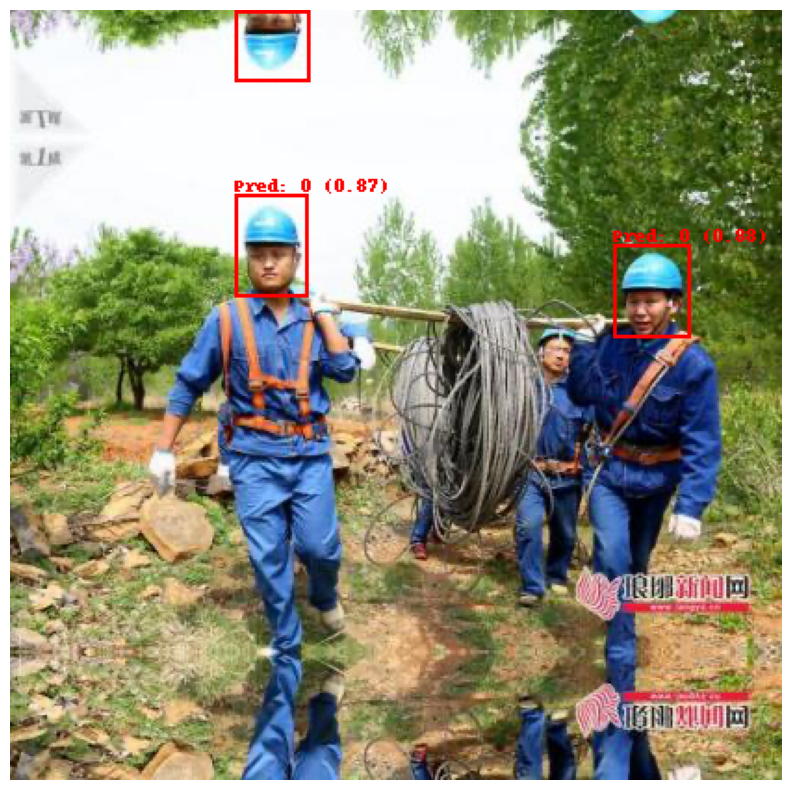

In [50]:
def compare_prediction_with_actual(image_path, model_path, confidence_threshold=0.8):
    model = YOLO(model_path)
    file_names = os.listdir(image_path)

    image_name = random.choice(file_names)
    image_full_path = os.path.join(image_path, image_name)

    img = Image.open(image_full_path).convert("RGB")

    results = model.predict(source=image_full_path, conf=confidence_threshold)

    predicted_boxes = results[0].boxes.xyxy.cpu().numpy() 
    predicted_confidences = results[0].boxes.conf.cpu().numpy()
    predicted_classes = results[0].boxes.cls.cpu().numpy()

    ground_truth_boxes = []  # Format: [[x1, y1, x2, y2], ...]

    draw = ImageDraw.Draw(img)

    for box, conf, cls in zip(predicted_boxes, predicted_confidences, predicted_classes):
        x1, y1, x2, y2 = box
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.text((x1, y1 - 10), f"Pred: {int(cls)} ({conf:.2f})", fill="red")

    for box in ground_truth_boxes:
        x1, y1, x2, y2 = box
        draw.rectangle([x1, y1, x2, y2], outline="blue", width=2)
        draw.text((x1, y1 - 10), "GT", fill="blue")

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

image_ref = "/kaggle/input/hard-hat-detection/images/hard_hat_workers208.png"  
image_path = "/kaggle/input/hard-hat-detection/images" 
yolo_model_path = "/kaggle/working/runs/detect/train6/weights/best.pt" 

compare_prediction_with_actual(image_path, yolo_model_path, confidence_threshold=0.8)



image 1/1 /kaggle/input/hard-hat-detection/images/hard_hat_workers3893.png: 640x640 1 helmet, 15.3ms
Speed: 2.3ms preprocess, 15.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


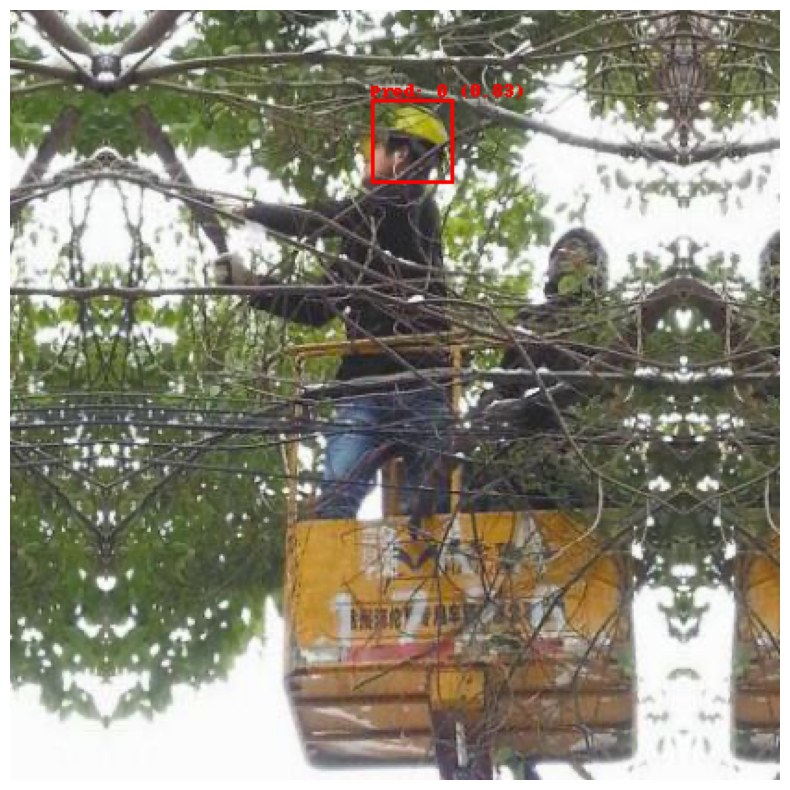

In [60]:
def compare_prediction_with_actual(image_path, model_path, confidence_threshold=0.5):
    model = YOLO(model_path)

    file_names = os.listdir(image_path)

    image_name = random.choice(file_names)
    image_full_path = os.path.join(image_path, image_name)

    img = Image.open(image_full_path).convert("RGB")

    results = model.predict(source=image_full_path, conf=confidence_threshold)

    predicted_boxes = results[0].boxes.xyxy.cpu().numpy() 
    predicted_confidences = results[0].boxes.conf.cpu().numpy()
    predicted_classes = results[0].boxes.cls.cpu().numpy()

    ground_truth_boxes = []  
    draw = ImageDraw.Draw(img)

    for box, conf, cls in zip(predicted_boxes, predicted_confidences, predicted_classes):
        x1, y1, x2, y2 = box
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.text((x1, y1 - 10), f"Pred: {int(cls)} ({conf:.2f})", fill="red")

    for box in ground_truth_boxes:
        x1, y1, x2, y2 = box
        draw.rectangle([x1, y1, x2, y2], outline="blue", width=2)
        draw.text((x1, y1 - 10), "GT", fill="blue")

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

image_ref = "/kaggle/input/hard-hat-detection/images/hard_hat_workers4915.png"  
image_path = "/kaggle/input/hard-hat-detection/images"  
yolo_model_path = "/kaggle/working/runs/detect/train6/weights/best.pt" 
compare_prediction_with_actual(image_path, yolo_model_path, confidence_threshold=0.8)



image 1/1 /kaggle/input/hard-hat-detection/images/hard_hat_workers3214.png: 640x640 1 helmet, 15.4ms
Speed: 2.2ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


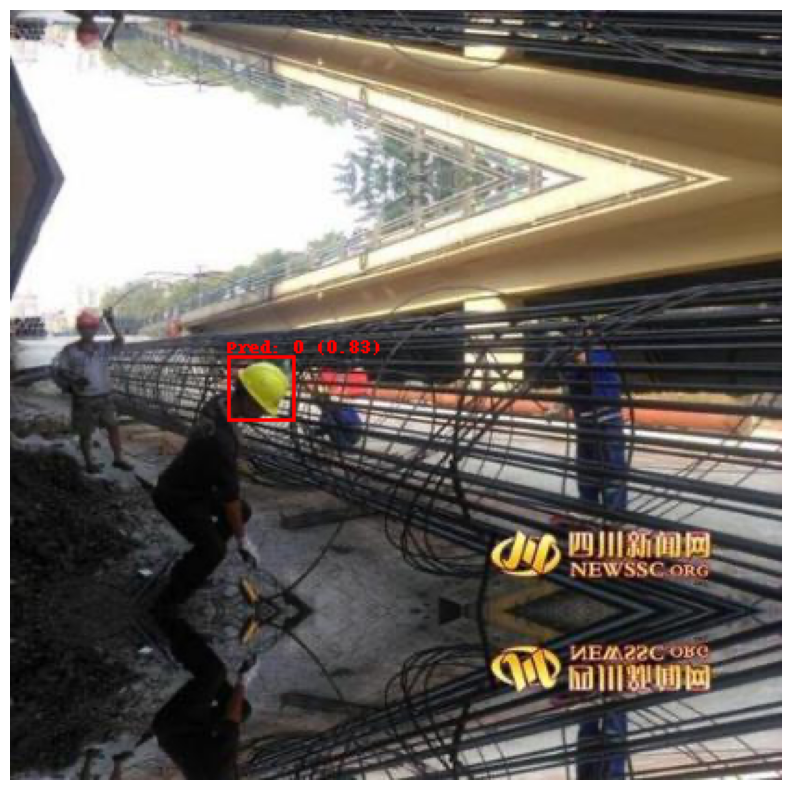

In [63]:
import os
import random
import torch
from ultralytics import YOLO
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def compare_prediction_with_actual(image_path, model_path, confidence_threshold=0.8):
    # Yolo indirme
    model = YOLO(model_path)

    # Dosya isimlerini çekme işlemi
    file_names = os.listdir(image_path)

    # Rastgele fotoğraf seçme
    image_name = random.choice(file_names)
    image_full_path = os.path.join(image_path, image_name)

    # Fotoğrafı yükleme
    img = Image.open(image_full_path).convert("RGB")

    # Tahminleme yapma
    results = model.predict(source=image_full_path, conf=confidence_threshold)

    # Tahminlemeleri çıkartma
    predicted_boxes = results[0].boxes.xyxy.cpu().numpy()  # x1, y1, x2, y2
    predicted_confidences = results[0].boxes.conf.cpu().numpy()
    predicted_classes = results[0].boxes.cls.cpu().numpy()

    ground_truth_boxes = []  # Format: [[x1, y1, x2, y2], ...]

    # Görselleştirme
    draw = ImageDraw.Draw(img)

    # Kutu çiz
    for box, conf, cls in zip(predicted_boxes, predicted_confidences, predicted_classes):
        x1, y1, x2, y2 = box
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.text((x1, y1 - 10), f"Pred: {int(cls)} ({conf:.2f})", fill="red")

    # Kutu çiz
    for box in ground_truth_boxes:
        x1, y1, x2, y2 = box
        draw.rectangle([x1, y1, x2, y2], outline="blue", width=2)
        draw.text((x1, y1 - 10), "GT", fill="blue")

    # Fotoğraf ve tahmini göster
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

#örnek kullanım
image_ref = "/kaggle/input/hard-hat-detection/images/hard_hat_workers399.png"  #referans
image_path = "/kaggle/input/hard-hat-detection/images"  #test
yolo_model_path = "/kaggle/working/runs/detect/train6/weights/best.pt"

compare_prediction_with_actual(image_path, yolo_model_path, confidence_threshold=0.8)

In [56]:
#Youtube üzerinden video indirme
!yt-dlp -f mp4 "https://www.youtube.com/watch?v=3G6qWa86XwI" -o "/kaggle/working/video.mp4"


[youtube] Extracting URL: https://www.youtube.com/watch?v=3G6qWa86XwI
[youtube] 3G6qWa86XwI: Downloading webpage
[youtube] 3G6qWa86XwI: Downloading ios player API JSON
[youtube] 3G6qWa86XwI: Downloading mweb player API JSON
[youtube] 3G6qWa86XwI: Downloading player 03dbdfab
[youtube] 3G6qWa86XwI: Downloading m3u8 information
[info] 3G6qWa86XwI: Downloading 1 format(s): 18
[download] Destination: /kaggle/working/video.mp4
[download] 100% of    2.17MiB in 00:00:00 at 5.46MiB/s0;33m00:000m


In [64]:
#indirilen video üzerinde tahminleme yapma
!yolo detect predict model="/kaggle/working/runs/detect/train6/weights/best.pt" source="/kaggle/working/video.mp4"

Ultralytics 8.3.54 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs

video 1/1 (frame 1/842) /kaggle/working/video.mp4: 384x640 (no detections), 76.4ms
video 1/1 (frame 2/842) /kaggle/working/video.mp4: 384x640 (no detections), 12.2ms
video 1/1 (frame 3/842) /kaggle/working/video.mp4: 384x640 (no detections), 12.2ms
video 1/1 (frame 4/842) /kaggle/working/video.mp4: 384x640 (no detections), 12.2ms
video 1/1 (frame 5/842) /kaggle/working/video.mp4: 384x640 (no detections), 12.2ms
video 1/1 (frame 6/842) /kaggle/working/video.mp4: 384x640 (no detections), 12.2ms
video 1/1 (frame 7/842) /kaggle/working/video.mp4: 384x640 (no detections), 12.2ms
video 1/1 (frame 8/842) /kaggle/working/video.mp4: 384x640 (no detections), 11.3ms
video 1/1 (frame 9/842) /kaggle/working/video.mp4: 384x640 (no detections), 11.4ms
video 1/1 (frame 10/842) /kaggle/working/video.mp4: 384x640 (no detections), 11.3